# Working with Time Series

In this session we'll see how we can use *pandas* to process time series data.

## What is a time series?

A time series is a series of data points that are in time order. In many cases we'll have the time to which each point corresponds.

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fnaadispeaks.files.wordpress.com%2F2016%2F12%2Fairline1_web-0.jpg&f=1&nofb=1)

The main difference with this kind of data, is that the value of a data point might be influenced by its preceding data points (i.e. the data points might form some sort of "pattern" in time, like we can see in the Figure above). This property is referred to as [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) and can be used to **predict** the values of future data points, based on their past. More on that in a future tutorial.


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Working with time

To work with time, pandas uses the [datetime](https://docs.python.org/3/library/datetime.html](https://docs.python.org/3/library/datetime.html) package.

### Timestamp

The fundamental building-block for working with time in computers is the **timestamp**. A timestamp represents a moment in time. All other units of time that we know of (hour, day, etc.) are formed as the *range* between two timestamps. 

In [2]:
now = pd.Timestamp('now')
now

Timestamp('2021-01-15 10:27:28.449413')

The `now` object above is a timestamp that represents the moment in time when the object was created. 

The timestamp object contains various properties with which we can extact information relevant to us. For example: 

In [3]:
print('Year:    ', now.year)
print('Month:   ', now.month)
print('Day:     ', now.day)
print('Hour:    ', now.hour)
print('Minute:  ', now.minute)
print('Second:  ', now.second)
print('Microsec:', now.microsecond)

Year:     2021
Month:    1
Day:      15
Hour:     10
Minute:   27
Second:   28
Microsec: 449413


A timestamp can be split into two components for convenience, a date and a time:

In [4]:
print('Date:', now.date())
print('Time:', now.time())

Date: 2021-01-15
Time: 10:27:28.449413


Also it contains **calendar information** about that specific date.

In [5]:
print('Day-of-week (int): ', now.dayofweek)   # weekday in number (0 is Sunday)
print('Day-of-week (name):', now.day_name())  # weekday
print('Day-of-year (int): ', now.dayofyear)   # what day of the year is this
print('Number of days in month:', now.daysinmonth)  # how many days does this month have
print('Is this a leap year?', now.is_leap_year)

Day-of-week (int):  4
Day-of-week (name): Friday
Day-of-year (int):  15
Number of days in month: 31
Is this a leap year? False


### Timedelta

The timestamp object is very useful because we can define **operations** between dates. Suppose we want to see how many days occurred from March 22, 2020 to May 4, 2020. 

In [6]:
d1 = pd.Timestamp(2020, 3, 22)  # March 22, 2020, time=00:00:00
d2 = pd.Timestamp(2020, 5, 4, 12)  # May 5, 2020, time=12:00:00

diff = d2 - d1  # difference between d2 and d1
diff

Timedelta('43 days 12:00:00')

Notice `diff` is a `Timedelta` object. These objects are used to represent the relative distance between timestamps. 

`diff` shows a difference of 43 days and 12 hours. It computed the distance between dates **separately** than the distance between hours!

We can access these through the following attributes:

In [7]:
diff.days, diff.seconds

(43, 43200)

#### Exercise 1: Compute the total difference in hours between d1 and d2

To do this we need to convert the seconds and days to hours.

In [8]:
h1 = diff.days * 24       # 24 hours in a day
h2 = diff.seconds / 3600  # 3600 seconds in an hour

print('Total hours:', h1 + h2)

Total hours: 1044.0


Second way, a bit more pythonic:

In [9]:
print('Total hours:', diff / pd.Timedelta(hours=1)) 

Total hours: 1044.0


`Timedelta` objects are also very useful to compute relative distances between dates.

For example, we want to find what day it was 5 full weeks ago:

In [10]:
fiveweeks = pd.Timedelta(days=7*5)  # 5 weeks = 35 days ago
print('Date 5-weeks ago:', (now - fiveweeks).date())

# or alternatively

fiveweeks = pd.Timedelta(weeks=5)  # 5 weeks
print('Date 5-weeks ago:', (now - fiveweeks).date())

Date 5-weeks ago: 2020-12-11
Date 5-weeks ago: 2020-12-11


#### Exercise 2: What day will it be 100 days from today?

We can use `Timedelta` with the `+` operator to find that out.

In [11]:
print('Date 100-days from now:', (now + pd.Timedelta(days=100)).date())

Date 100-days from now: 2021-04-25


Timedelta can be created from weeks, days, hours, minutes, seconds, milliseconds, microseconds and nanoseconds.

### Comparing dates

Timestamps are also neat because they **fully support logical operations**, for example:

In [12]:
d1 < d2, d1 > d2

(True, False)

Which has the added benefit of being able to:

- **sort** a list of dates
- compute the **minimum/maximum** of a list of dates

In [13]:
list_of_dates = [d2, d1, now]

print('Minimum date:', min(list_of_dates).date())
print('Maximum date:', max(list_of_dates).date())

sorted(list_of_dates)

Minimum date: 2020-03-22
Maximum date: 2021-01-15


[Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-05-04 12:00:00'),
 Timestamp('2021-01-15 10:27:28.449413')]

### Range of dates

Say we want to create a list containing all days from `d1` to `d2`. This could be done obviously manually:

In [14]:
list_of_dates = [d1 + pd.Timedelta(days=i)for i in range(diff.days)]
list_of_dates

[Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-03-27 00:00:00'),
 Timestamp('2020-03-28 00:00:00'),
 Timestamp('2020-03-29 00:00:00'),
 Timestamp('2020-03-30 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-04-02 00:00:00'),
 Timestamp('2020-04-03 00:00:00'),
 Timestamp('2020-04-04 00:00:00'),
 Timestamp('2020-04-05 00:00:00'),
 Timestamp('2020-04-06 00:00:00'),
 Timestamp('2020-04-07 00:00:00'),
 Timestamp('2020-04-08 00:00:00'),
 Timestamp('2020-04-09 00:00:00'),
 Timestamp('2020-04-10 00:00:00'),
 Timestamp('2020-04-11 00:00:00'),
 Timestamp('2020-04-12 00:00:00'),
 Timestamp('2020-04-13 00:00:00'),
 Timestamp('2020-04-14 00:00:00'),
 Timestamp('2020-04-15 00:00:00'),
 Timestamp('2020-04-16 00:00:00'),
 Timestamp('2020-04-17 00:00:00'),
 Timestamp('2020-04-18 00:00:00'),
 Timestamp('2020-04-

Or through a pandas function specialized for this task:

In [15]:
list_of_dates = pd.date_range(start=d1, end=d2, freq='1D')
list_of_dates

DatetimeIndex(['2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
               '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
               '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
               '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
               '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
               '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04'],
              dtype='datetime64[ns]', freq='D')

#### Exercise 3: Create a list of 10 timestamps, starting from today, with 12-hour intervals 

In [16]:
list_of_dates = pd.date_range(start=now, periods=10, freq='12H')
list_of_dates

DatetimeIndex(['2021-01-15 10:27:28.449413', '2021-01-15 22:27:28.449413',
               '2021-01-16 10:27:28.449413', '2021-01-16 22:27:28.449413',
               '2021-01-17 10:27:28.449413', '2021-01-17 22:27:28.449413',
               '2021-01-18 10:27:28.449413', '2021-01-18 22:27:28.449413',
               '2021-01-19 10:27:28.449413', '2021-01-19 22:27:28.449413'],
              dtype='datetime64[ns]', freq='12H')

### Date formatting

A very important part of mastering datetime in python are **date format strings**. These are used for 2 reasons:

- **displaying** dates in the format we want
- **parsing** dates from an arbitrary format

Dates can be displayed in many different ways. We need a way to convert these different ways to and from datetime.

Parsing dates from strings isn't that easy of a task:
- Think of this date: `'5-6-2020'`. This date is interpreted differently in the United States and in Europe. We need a way to specify that the first digit represents the day and the second represents the month, or vice versa.
- Different symbols can be used to separate the day, month and year of a date, (e.g. `-` and `/`).
- A year can be abbreviated (e.g. '99 or 1999)
- A month can be written in many different ways (e.g. `3`, `03`, `March`, `Mar.`), etc.

Much like the encoding in text, a date is useless unless we know what format it has, though the latter **can be inferred** in most cases. We use format strings to specify what format is being used to represent the date.


In [70]:
fmt1 = '%d/%m/%Y, %H o\'clock, %M:%S'
fmt2 = '%I %p %m:%S\n%A, %B %d, %Y'


print('Format1:\n', now.strftime(fmt1), sep='')
print('\nFormat2:\n', now.strftime(fmt2), sep='')

Format1:
15/01/2021, 10 o'clock, 27:28

Format2:
10 AM 01:28
Friday, January 15, 2021


If you can tell from above, I used various formatting options (`'%d'`, `'%m'`, `'%Y'`, etc.) to specify where each component of the timestamp (day, month, year, etc.) would be placed at. The same principle can be used for specifying the format to parse the date from (e.g. if we had `07-01-2021`, we could use the format string `'%d-%m-%Y'`to remove the ambiguity in which digit represents the day and which the month).

A complete documentation of all format codes can be found [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes).

This will become very handy later on when we want to parse dates.

## DateTime in Pandas DataFrames

The main question now is how can we deal if a DataFrame column is in DateTime format. First, though, let's see how we can bring it in that format.

In [18]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

df = pd.read_csv(data_url)
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


Here we loaded a DataFrame with two columns, one called *Month* that is in a format that can represents a date and one called *Passengers* that is an integer. We want pandas to interpret column *Month* as date, so that we can perform operations on it!

To do this we can call [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html).

In [19]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)
df

Month         datetime64[ns]
Passengers             int64
dtype: object


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


As we can see the column has been converted to datetime, and its format has been **inferred** from the data. If the format is not parsed correctly, we can always specify how it should by interpreted, through a format string:

```python
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
```

Another, way would be to parse the dates, direcly when loading the csv.

In [20]:
df = pd.read_csv(data_url, parse_dates=['Month'])
df

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


### Errors

If pandas didn't infer the format correctly, or you have selected an wrong date format, then you should be aware of how pandas will handle the errors. There is a parameter in `pd.to_datetime()` called `errors`, which specifies this:

- If `errors='raise'`, then any invalid parsing will raise an exception.
- If `errors='coerce'`, then any invalid parsing will be set as `NaT`.
- If `errors='ignore'`, then any invalid parsing will return the input.

*Note*: `NaT` is the equivalent of `NaN` for Time.

#### Exercise 4: What is the total number of passengers after 1955?

This is a simple case of filtering, but be careful:


In [21]:
pd.to_datetime('1955')

Timestamp('1955-01-01 00:00:00')

`pd.to_datetime('1955')` is interpreted as `1955-01-01`, which means that if we try to take all dates larger than 1955:

In [22]:
df[df['Month'] > pd.to_datetime('1955')].head()

,Month,Passengers
73,1955-02-01,233
74,1955-03-01,267
75,1955-04-01,269
76,1955-05-01,270
77,1955-06-01,315


we would also get all months after January in the year 1955!

This means that in order to do the proper comparison we'd need to do the following:

In [23]:
df[df['Month'] >= pd.to_datetime('1956')].head()

,Month,Passengers
84,1956-01-01,284
85,1956-02-01,277
86,1956-03-01,317
87,1956-04-01,313
88,1956-05-01,318


Datetime also allows for comparisons between dates and strings, which lets us simplify the expression above:

In [24]:
df[df['Month'] >= '1956'].head()

,Month,Passengers
84,1956-01-01,284
85,1956-02-01,277
86,1956-03-01,317
87,1956-04-01,313
88,1956-05-01,318


To answer the question:

In [25]:
df[df['Month'] >= '1956']['Passengers'].sum()

23786

#### Exercise 5: What is the average yearly number of passengers?

The easiest way yo do this is to create a new column called *Year*. This will simply be an integer indicating the year of the datetime column. This will be used to group the rows by their year and compute their mean.

In [26]:
df['Year'] = df['Month'].apply(lambda x: x.year)
df.groupby('Year')['Passengers'].mean()

Year
1949    126.666667
1950    139.666667
1951    170.166667
1952    197.000000
1953    225.000000
1954    238.916667
1955    284.000000
1956    328.250000
1957    368.416667
1958    381.000000
1959    428.333333
1960    476.166667
Name: Passengers, dtype: float64

A second way to make the year column (without `Series.apply()`) would be:

```python
df['Year'] = df['Month'].dt.year
```




### Datetime as index

A datetime column can also be set as the **index** of a dataframe. This enables the following functionality:

In [27]:
df.index = df['Month']
df['1955':'1956']  # slice by dates (keep all 1955 and 1956 entries)

,Month,Passengers,Year
Month,,,
1955-01-01,1955-01-01,242,1955
1955-02-01,1955-02-01,233,1955
1955-03-01,1955-03-01,267,1955
1955-04-01,1955-04-01,269,1955
1955-05-01,1955-05-01,270,1955
1955-06-01,1955-06-01,315,1955
1955-07-01,1955-07-01,364,1955
1955-08-01,1955-08-01,347,1955
1955-09-01,1955-09-01,312,1955


Which can be used to answer exercise 4 more simply:

In [28]:
df.loc['1956':, 'Passengers'].sum()

23786

## Plotting timeseries

A big part of analyzing timeseries data is the ability to plot them. The typical timeseries plot has *time* as its x-axis and the value(s) on the y-axis.

In our case this would look something like this:

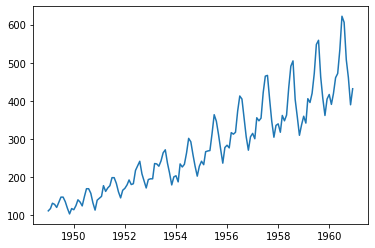

In [29]:
plt.plot(df['Month'], df['Passengers'])

Frequently, [`DataFrame.plot()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) or [`Series.plot()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.html) are used to plot timeseries, which is simpler in most cases.

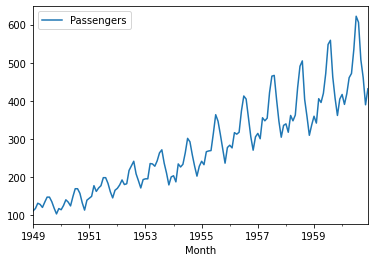

In [30]:
df[['Passengers']].plot()  # DataFrame.plot()

`DataFrame.plot()` and `Series.plot()` both use matplotlib. In fact they both return the Axes objects that were used to dray the figures on. We can manipulate these like we have seen in previous tutorials. For example:

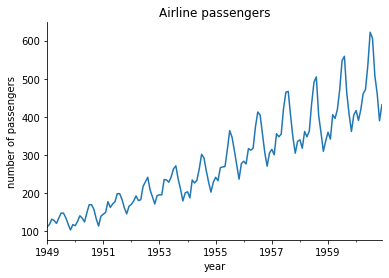

In [31]:
ax = df['Passengers'].plot()  # Series.plot()

# Title and axis labels
ax.set_title('Airline passengers')
ax.set_ylabel('number of passengers')
ax.set_xlabel('year')

# I really dislike spines ;)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend has no point with just one line
ax.legend().remove()

Another way is to pass an axis object as an argument to `DataFrame.plot()` or `Series.plot()`. This is very useful for subplots.

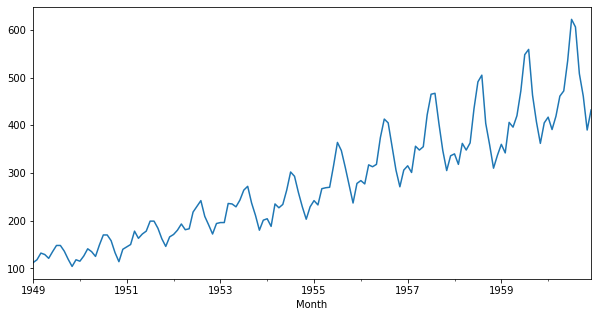

In [32]:
plt.figure(figsize=(10, 5))  # create a Figure

ax = plt.gca()  # get current Axis object

# manipulate ax as we wish...

df['Passengers'].plot(ax=ax)  # pass the Axis as an argument to Series.plot()  

Let's load [another dataset](https://ourworldindata.org/coronavirus-source-data) containing statistics about COVID-19, which is more interesting to visualize as it has more variables.

In [33]:
covid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
covid.index = pd.to_datetime(covid['date'])

*Cool note: This dataset gets updated daily, so the figures will get updated automatically with new data!*

In [34]:
covid.sample(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-28,PER,South America,Peru,2020-10-28,892497.0,1923.0,2625.571,34257.0,60.0,54.571,27068.457,58.322,79.631,1038.977,1.820,1.655,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12856.0,1105618.0,33.532,0.390,10781.0,0.327,0.042,23.8,tests performed,NaN,NaN,NaN,NaN,NaN,74.07,32971846.0,25.129,29.1,7.151,4.455,12236.706,3.5,85.755,5.95,4.8,NaN,NaN,1.60,76.74,0.750
2020-07-21,NLD,Europe,Netherlands,2020-07-21,52307.0,165.0,135.000,6155.0,0.0,0.143,3052.663,9.629,7.879,359.209,0.000,0.008,1.46,15.0,0.875,90.0,5.252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13804.0,0.806,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,39.81,17134873.0,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.931
2020-10-13,LTU,Europe,Lithuania,2020-10-13,6366.0,118.0,142.857,106.0,3.0,1.000,2338.472,43.346,52.477,38.938,1.102,0.367,1.38,NaN,NaN,149.0,54.733,NaN,NaN,NaN,NaN,7900.0,796114.0,292.443,2.902,6388.0,2.347,0.022,44.7,tests performed,NaN,NaN,NaN,NaN,NaN,48.61,2722291.0,45.135,43.5,19.002,13.778,29524.265,0.7,342.989,3.67,21.3,38.0,NaN,6.56,75.93,0.858
2020-04-14,GNB,Africa,Guinea-Bissau,2020-04-14,38.0,0.0,0.714,NaN,NaN,0.000,19.309,0.000,0.363,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1967998.0,66.191,19.4,3.002,1.565,1548.675,67.1,382.474,2.42,NaN,NaN,6.403,NaN,58.32,0.455
2021-01-05,GRC,Europe,Greece,2021-01-05,141453.0,927.0,639.571,5051.0,40.0,45.857,13571.164,88.937,61.361,484.599,3.838,4.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11817.0,2840278.0,272.500,1.134,9322.0,0.894,0.069,14.6,samples tested,16233.0,6258.0,2168.0,0.16,208.0,NaN,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.870


Plot new case progression in Greece.

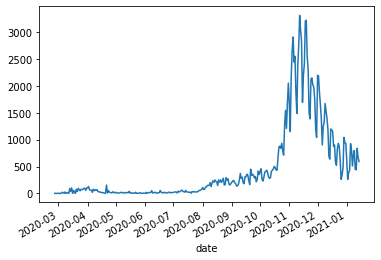

In [35]:
gr = covid[covid['location'] == 'Greece']
gr['new_cases'].plot();  # I use the semicolon sometimes to supress 
                         # the Axis repr form appearing in stdout

The dataset also has a smoothed version of this Figure. If we call `.plot()` in a DataFrame containing these two variables, it will plot them on the same axes.

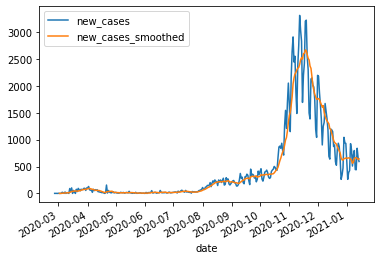

In [36]:
gr = covid[covid['location'] == 'Greece']
gr[['new_cases', 'new_cases_smoothed']].plot();  # DataFrame.plot() with two columns

There is also an argument called `subplots`, which allows us to plot each column on a different axis. 

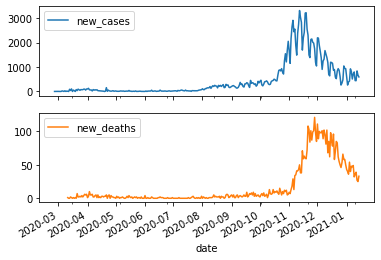

In [37]:
gr[['new_cases', 'new_deaths']].plot(subplots=True);

## Timeseries manipulation

In order to perform analysis on timeseries, sometimes it might be necessary to manipulate them in their time dimension. The three main ones we'll see are:

- shifting
- rolling
- resampling

### Shifting

Shifting is the operation of **moving** a timeseries along the time axis. One use case of this operation is to compare two series that are **not aligned**.

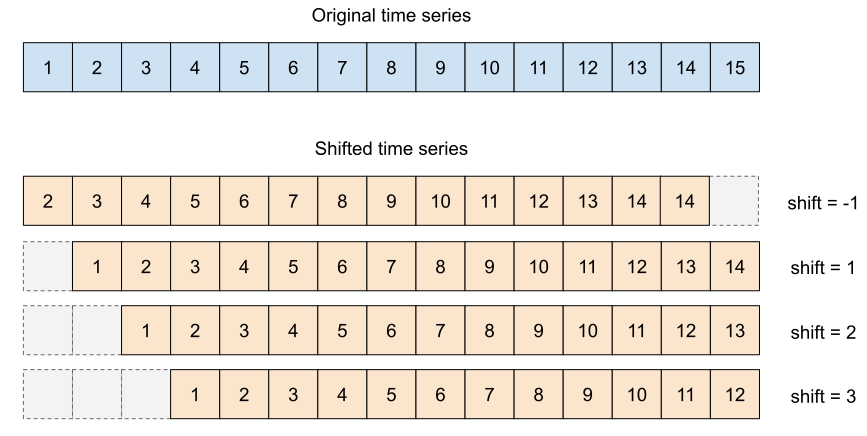

By shifting the data, we essentially mean that we shift the alignment between time and data. Traditionally there were two ways to do this:

- Shift the **data**, using [`DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)
- ~~Shift the **time index**, using [`DataFrame.tshift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tshift.html).~~ 

The latter is deprecated since `pandas==1.1.0` and should be avoided.

In [38]:
p1 = df['Passengers']
p2 = df['Passengers'].shift(3)
p3 = df['Passengers'].shift(-3)

shifted = pd.DataFrame({'Original': p1, 'Shift (+3)': p2, 'Shift (-3)': p3})
shifted

,Original,Shift (+3),Shift (-3)
Month,,,
1949-01-01,112,NaN,129.0
1949-02-01,118,NaN,121.0
1949-03-01,132,NaN,135.0
1949-04-01,129,112.0,148.0
1949-05-01,121,118.0,148.0
...,...,...,...
1960-08-01,606,472.0,390.0
1960-09-01,508,535.0,432.0
1960-10-01,461,622.0,NaN


The effect of shifting the data can be seen above. `.shift(n)` moves the data in timestep $t$ to $t+n$, i.e. $x_t \rightarrow x_{t+n}$. It is important to note that bt using `.shift()` the time index **remains constant**. Any data that gets "pushed" over the time index is lost, while the data that is missing is substituted by `NaN`.

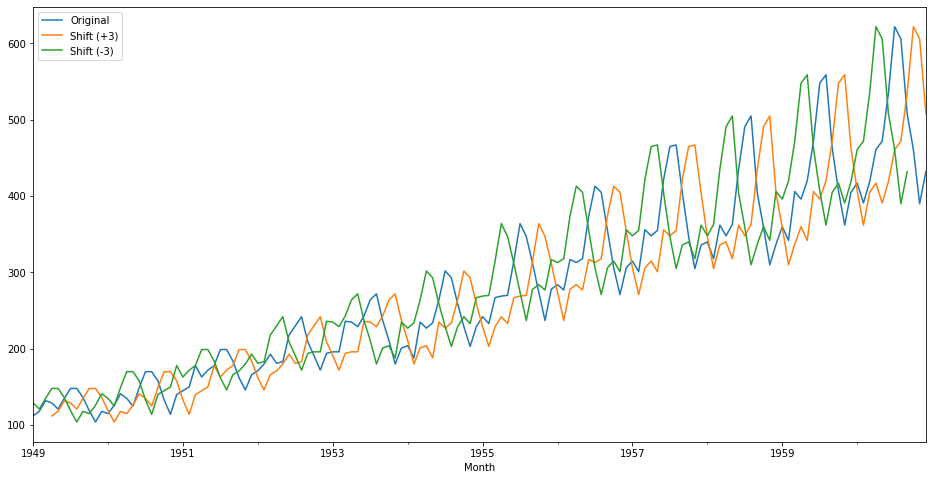

In [39]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
shifted.plot(ax=ax)

Notice how the orange line doesn't start at the beginning of the axis and the green line doesn't end at the end of the axis.

#### Exercise 6: Compare the progression of COVID-19 in Spain and Italy for the first two weeks of the outbreaks in their respective countries.

First, well need to find when the outbreak started in each country.

In [40]:
spain = covid.loc[covid['location'] == 'Spain']
italy = covid.loc[covid['location'] == 'Italy']
italy['new_cases'][:30]

date
2020-01-31      2.0
2020-02-01      0.0
2020-02-02      0.0
2020-02-03      0.0
2020-02-04      0.0
2020-02-05      0.0
2020-02-06      0.0
2020-02-07      1.0
2020-02-08      0.0
2020-02-09      0.0
2020-02-10      0.0
2020-02-11      0.0
2020-02-12      0.0
2020-02-13      0.0
2020-02-14      0.0
2020-02-15      0.0
2020-02-16      0.0
2020-02-17      0.0
2020-02-18      0.0
2020-02-19      0.0
2020-02-20      0.0
2020-02-21     17.0
2020-02-22     42.0
2020-02-23     93.0
2020-02-24     74.0
2020-02-25     93.0
2020-02-26    131.0
2020-02-27    202.0
2020-02-28    233.0
2020-02-29    240.0
Name: new_cases, dtype: float64

From the above, we can tell see that while Italy had initial cases from as early as 31-01-2020, the outbreak didn't happen until 21-02-2020. We'll define the beginning of the outbreak as the first date in February, after which, the cases don't drop to less than 10.

In [41]:
def find_day_zero(country, threshold=10):

    mar_1st = '2020-03-01'

    # Limit the search for all dates until march (we are interested only in the first outbreak)
    country_feb = country[:mar_1st]  

    # Find the last date with 0 new cases
    day0 = country_feb[country_feb < threshold].index[-1]
  
    return day0


day0_italy = find_day_zero(italy['new_cases'])
day0_spain = find_day_zero(spain['new_cases'])
diff = day0_spain - day0_italy

print('Day zero in Italy:', day0_italy.date())
print('Day zero in Spain:', day0_spain.date())
print('Difference: {} days'.format(diff.days))

Day zero in Italy: 2020-02-20
Day zero in Spain: 2020-02-27
Difference: 7 days


As we can see from above the outbreak in Italy started one week before the one in Spain. To properly compare the progression in the two, we need to account for this offset. 

To accomplish this, we can either shift Italy's new cases by $+7$ days or Spain's by $-7$ days. We'll do the first. 

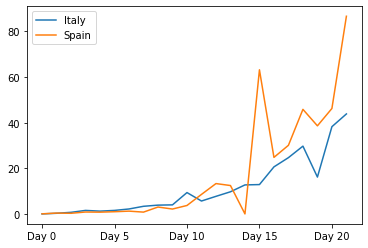

In [42]:
days_to_compare = 21  # we are interested in the first two weeks of the outbreaks
target_variable = 'new_cases_per_million'  # for a fairer comparison, well focus on new cases per 1m

italy_shifted = italy[target_variable].shift(diff.days)

compare = pd.DataFrame({'Italy': italy_shifted, 'Spain': spain[target_variable]})
compare = compare.loc[day0_spain:day0_spain + pd.Timedelta(days=days_to_compare)]
compare.index = ['Day {}'.format(i) for i in range(days_to_compare + 1)]

compare.plot()

While Italy was progressing worse until day 10 or the outbreak, spain outpaced it in the following days.

#### Exercise 7: Compare the ratio of cases to deaths in Italy for the first 3 months of the outbreak.

The problem with this task is that these two variables are naturally offset. Someone that that dies was diagnosed with covid weeks before. 

First, let's plot these two to compare them.

Day-0 offset: 8 days
Peak offset:  7 days


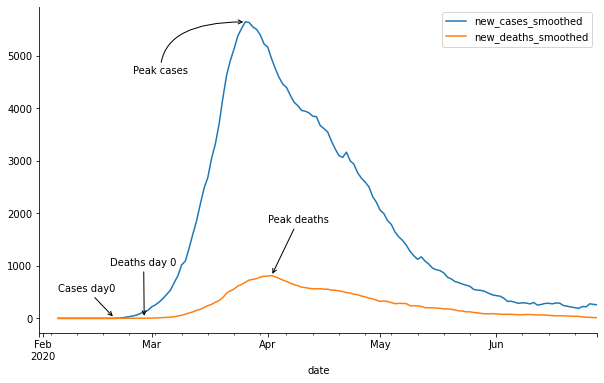

In [43]:
plt.figure(figsize=(10, 6))

three_months = day0_italy + pd.Timedelta(days=90)

deaths_day0 = find_day_zero(italy['new_deaths'], threshold=5)

cases_max_id = italy.index[italy.loc[:three_months, 'new_cases_smoothed'].argmax()]
cases_max = italy.loc[cases_max_id, 'new_cases_smoothed']
deaths_max_id = italy.index[italy.loc[:three_months, 'new_deaths_smoothed'].argmax()]
deaths_max = italy.loc[deaths_max_id, 'new_deaths_smoothed']

ax = plt.gca()
italy[['new_cases_smoothed', 'new_deaths_smoothed']][:150].plot(ax=ax)

ax.annotate('Cases day0', (day0_italy, 10), xytext=(day0_italy-pd.Timedelta(days=15), 500), arrowprops={'arrowstyle': '->'})
ax.annotate('Deaths day 0', (deaths_day0, 10), xytext=(deaths_day0-pd.Timedelta(days=9), 1000), arrowprops={'arrowstyle': '->'})

ax.annotate('Peak cases', (cases_max_id, cases_max), xytext=(cases_max_id-pd.Timedelta(days=30), cases_max-1000), arrowprops={'arrowstyle': '->', 'connectionstyle':'angle3'})
ax.annotate('Peak deaths', (deaths_max_id, deaths_max), xytext=(deaths_max_id-pd.Timedelta(days=1), deaths_max+1000), arrowprops={'arrowstyle': '->'})

ax.spines['top'].set_visible(False)  # I really dislike spines ;)
ax.spines['right'].set_visible(False)

print('Day-0 offset: {} days'.format((deaths_day0 - day0_italy).days))
print('Peak offset:  {} days'.format((deaths_max_id - cases_max_id).days))

Out of these two offsets, we'll keep the peak, because it's less arbitrarily defined than the other.

Now we need to align the two series.

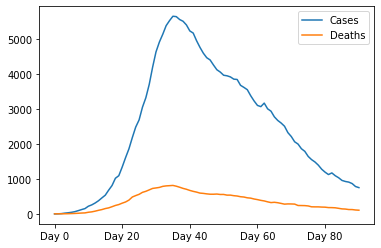

In [44]:
compare = pd.DataFrame({'Cases': italy['new_cases_smoothed'],
                        'Deaths': italy['new_deaths_smoothed'].shift(-7)})

compare = compare[day0_italy:three_months]  # apply the 3-month filter after shift to avoid NaN values

compare.index = ['Day {}'.format(i) for i in range(len(compare))]

compare.plot()

Finally, let's compute the ratio of cases to deaths.

(0.0, 0.4)

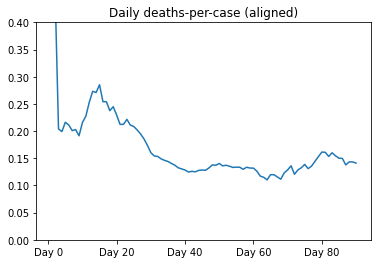

In [45]:
compare['Ratio'] = compare['Deaths'] / compare['Cases']

ax = compare['Ratio'].plot()
ax.set_title('Daily deaths-per-case (aligned)')
ax.set_ylim([0, 0.4])

The first few days the death-to-case ratio is very high, probably due to unreported cases before the beginning of the outbreak. Due to the ratio being constant later on we can assume that the offset is not far from the truth.

Let's see if we can confirm these numbers through the total stats.

In [46]:
italy.loc[three_months, 'total_deaths'] / italy.loc[three_months, 'total_cases']

0.1421948945303566

Even though the ratio the first days was high, its impact towards the totals is fairly low, due to the absolute numbers being low.

### Resampling

The next operation we'll see is resampling. Resampling is an operation that tries to **change the frequency** of the series, i.e. make it more dense or more sparse, while **preserving** it as faithfully as possible. 

If we compare it to shift:
- `.shift()` tried to *move* the series along the time axis, thus changing its time axis (i.e. the minimum and maximum date), while keeping the same number of data points
- resampling **changes the overall number of datapoints**, while keeping the **same time axis**.

While resampling can be performed in other types data as well, it is performed a bit differently in timeseries. It comes in two forms:

- **under-sampling**, which reduces the number of data points
- **over-sampling**, which increases the number of data points

Both can be accomplished through [`DataFrame.resample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

#### Undersampling

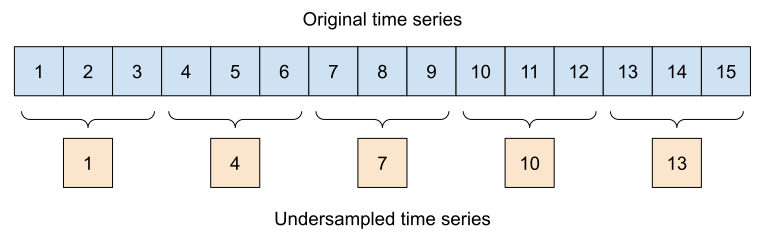

`.resample()` is essentially a `.groupby()` operation along the time axis. To perform it we need 2 things:

- a **new sampling frequency** (i.e. how sparse we want our new data points to be). The easiest way to define this is through a [date offset string](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).
- an **aggregation operation**, i.e. the operation with which we'll aggregate the data.

The syntax is similar to a regular `.groupby()`. For example, to keep one in every three datapoints in the dataset:

In [47]:
gr_cases = gr.loc['2020-02-25':, 'new_cases']
gr_cases.head(10)

date
2020-02-26     1.0
2020-02-27     2.0
2020-02-28     1.0
2020-02-29     0.0
2020-03-01     3.0
2020-03-02     0.0
2020-03-03     0.0
2020-03-04     2.0
2020-03-05    22.0
2020-03-06    14.0
Name: new_cases, dtype: float64

In [48]:
gr_cases.resample('3D').first().head(3)  # 3D = 3 days

date
2020-02-26    1.0
2020-02-29    0.0
2020-03-03    0.0
Freq: 3D, Name: new_cases, dtype: float64

To take the average weekly new cases:

In [49]:
gr_cases.resample('1W').mean().head(3)  # 1W = 1 week

date
2020-03-01     1.400000
2020-03-08     9.428571
2020-03-15    36.857143
Freq: W-SUN, Name: new_cases, dtype: float64

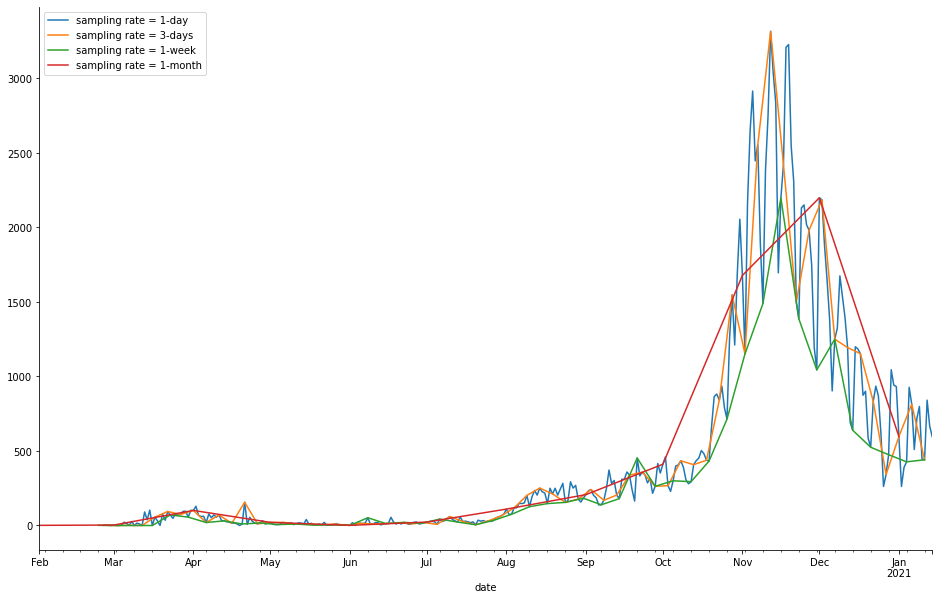

In [50]:
plt.figure(figsize=(16, 10))
ax = plt.gca()

gr_cases.plot(ax=ax, label='sampling rate = 1-day')
gr_cases.resample('5D').first().plot(ax=ax, label='sampling rate = 3-days')
gr_cases.resample('1W').first().plot(ax=ax, label='sampling rate = 1-week')
gr_cases.resample('1M').first().plot(ax=ax, label='sampling rate = 1-month')

plt.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

*Note: the weekly undersampling appears much more smooth because it aligns with the weekly periodicity of the new cases.*

#### Oversampling 

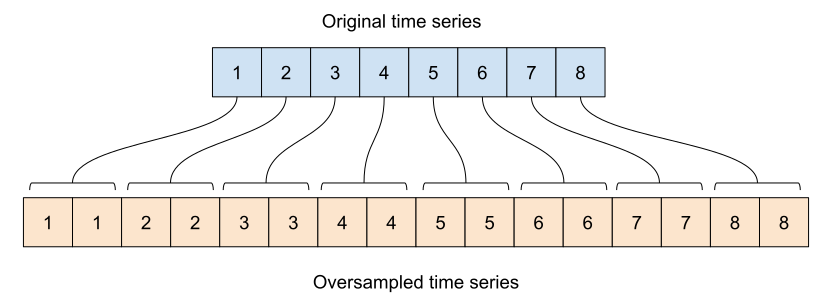

Oversampling is a conceptually more complicated operation, because we need to make new samples. Let's say we want to bring the daily cases to an hourly level. This means that for every datapoint in the series, we need to produce 24 new datapoints.

In [51]:
gr_cases.head(3)

date
2020-02-26    1.0
2020-02-27    2.0
2020-02-28    1.0
Name: new_cases, dtype: float64

In [52]:
gr_cases.resample('1H').asfreq().head(30)

date
2020-02-26 00:00:00    1.0
2020-02-26 01:00:00    NaN
2020-02-26 02:00:00    NaN
2020-02-26 03:00:00    NaN
2020-02-26 04:00:00    NaN
2020-02-26 05:00:00    NaN
2020-02-26 06:00:00    NaN
2020-02-26 07:00:00    NaN
2020-02-26 08:00:00    NaN
2020-02-26 09:00:00    NaN
2020-02-26 10:00:00    NaN
2020-02-26 11:00:00    NaN
2020-02-26 12:00:00    NaN
2020-02-26 13:00:00    NaN
2020-02-26 14:00:00    NaN
2020-02-26 15:00:00    NaN
2020-02-26 16:00:00    NaN
2020-02-26 17:00:00    NaN
2020-02-26 18:00:00    NaN
2020-02-26 19:00:00    NaN
2020-02-26 20:00:00    NaN
2020-02-26 21:00:00    NaN
2020-02-26 22:00:00    NaN
2020-02-26 23:00:00    NaN
2020-02-27 00:00:00    2.0
2020-02-27 01:00:00    NaN
2020-02-27 02:00:00    NaN
2020-02-27 03:00:00    NaN
2020-02-27 04:00:00    NaN
2020-02-27 05:00:00    NaN
Freq: H, Name: new_cases, dtype: float64

When oversampling, we usually want to **fill** the missing values, however we can't use the regular imputation techniques (e.g. fill with variable mean). We need to perform an operation called **interpolation**, which uses the nearest points in time to fill the missing values.

The simplest thing we can use is **forward fill**, i.e. copy the previous available datapoint.

In [53]:
gr_cases.resample('1H').asfreq().ffill().head(30)

date
2020-02-26 00:00:00    1.0
2020-02-26 01:00:00    1.0
2020-02-26 02:00:00    1.0
2020-02-26 03:00:00    1.0
2020-02-26 04:00:00    1.0
2020-02-26 05:00:00    1.0
2020-02-26 06:00:00    1.0
2020-02-26 07:00:00    1.0
2020-02-26 08:00:00    1.0
2020-02-26 09:00:00    1.0
2020-02-26 10:00:00    1.0
2020-02-26 11:00:00    1.0
2020-02-26 12:00:00    1.0
2020-02-26 13:00:00    1.0
2020-02-26 14:00:00    1.0
2020-02-26 15:00:00    1.0
2020-02-26 16:00:00    1.0
2020-02-26 17:00:00    1.0
2020-02-26 18:00:00    1.0
2020-02-26 19:00:00    1.0
2020-02-26 20:00:00    1.0
2020-02-26 21:00:00    1.0
2020-02-26 22:00:00    1.0
2020-02-26 23:00:00    1.0
2020-02-27 00:00:00    2.0
2020-02-27 01:00:00    2.0
2020-02-27 02:00:00    2.0
2020-02-27 03:00:00    2.0
2020-02-27 04:00:00    2.0
2020-02-27 05:00:00    2.0
Freq: H, Name: new_cases, dtype: float64

This can be done a bit better if we would fill the first half of the day with the previous day's cases and the second half with the next day's cases. This is called **nearest interpolation**, and can be accomplished with the [`.interpolate()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.resample.Resampler.interpolate.html) method.

In [72]:
gr_cases.resample('1H').asfreq().interpolate(method='nearest').head(30)

date
2020-02-26 00:00:00    1.0
2020-02-26 01:00:00    1.0
2020-02-26 02:00:00    1.0
2020-02-26 03:00:00    1.0
2020-02-26 04:00:00    1.0
2020-02-26 05:00:00    1.0
2020-02-26 06:00:00    1.0
2020-02-26 07:00:00    1.0
2020-02-26 08:00:00    1.0
2020-02-26 09:00:00    1.0
2020-02-26 10:00:00    1.0
2020-02-26 11:00:00    1.0
2020-02-26 12:00:00    1.0
2020-02-26 13:00:00    2.0
2020-02-26 14:00:00    2.0
2020-02-26 15:00:00    2.0
2020-02-26 16:00:00    2.0
2020-02-26 17:00:00    2.0
2020-02-26 18:00:00    2.0
2020-02-26 19:00:00    2.0
2020-02-26 20:00:00    2.0
2020-02-26 21:00:00    2.0
2020-02-26 22:00:00    2.0
2020-02-26 23:00:00    2.0
2020-02-27 00:00:00    2.0
2020-02-27 01:00:00    2.0
2020-02-27 02:00:00    2.0
2020-02-27 03:00:00    2.0
2020-02-27 04:00:00    2.0
2020-02-27 05:00:00    2.0
Freq: H, Name: new_cases, dtype: float64

To visually compare the two:

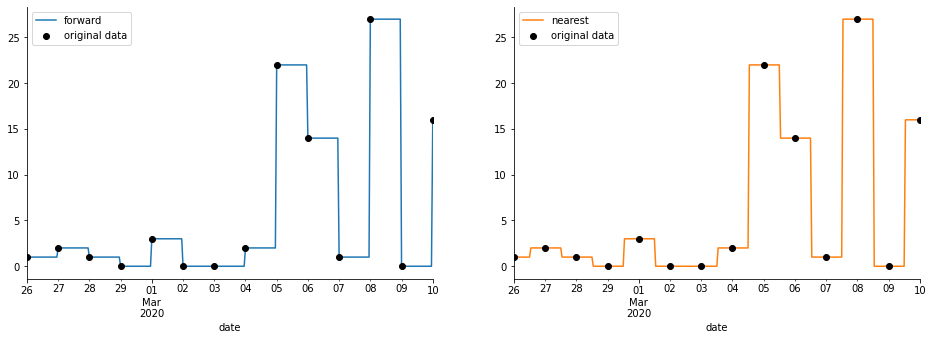

In [55]:
gr_cases2 = gr_cases[:'2020-03-10']
plt.figure(figsize=(16, 5))

ax = plt.subplot(121)
gr_cases2.resample('1H').asfreq().ffill().plot(ax=ax, label='forward')
ax.scatter(gr_cases2.index, gr_cases2, zorder=10, c='black', label='original data')
ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
gr_cases2.resample('1H').asfreq().interpolate(method='nearest').plot(ax=ax, label='nearest', c='C1')
ax.scatter(gr_cases2.index, gr_cases2, zorder=10, c='black', label='original data')

ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

The problem with these techniques is that there is a very steep change from hour to hour, when we transition to using the next day's data.

Another way to interpolate data more gradually is to perform **linear interpolation**, which selects the value according to its distance to the previous and next available datapoints.

For example if we want to interpolate a value at $10\%$ of the distance between two values $1$ and $2$, it will get the value $0.9 \cdot 1 + 0.1 \cdot 2 = 1.1$.

In [56]:
gr_cases.resample('1H').asfreq().interpolate().head(30)

date
2020-02-26 00:00:00    1.000000
2020-02-26 01:00:00    1.041667
2020-02-26 02:00:00    1.083333
2020-02-26 03:00:00    1.125000
2020-02-26 04:00:00    1.166667
2020-02-26 05:00:00    1.208333
2020-02-26 06:00:00    1.250000
2020-02-26 07:00:00    1.291667
2020-02-26 08:00:00    1.333333
2020-02-26 09:00:00    1.375000
2020-02-26 10:00:00    1.416667
2020-02-26 11:00:00    1.458333
2020-02-26 12:00:00    1.500000
2020-02-26 13:00:00    1.541667
2020-02-26 14:00:00    1.583333
2020-02-26 15:00:00    1.625000
2020-02-26 16:00:00    1.666667
2020-02-26 17:00:00    1.708333
2020-02-26 18:00:00    1.750000
2020-02-26 19:00:00    1.791667
2020-02-26 20:00:00    1.833333
2020-02-26 21:00:00    1.875000
2020-02-26 22:00:00    1.916667
2020-02-26 23:00:00    1.958333
2020-02-27 00:00:00    2.000000
2020-02-27 01:00:00    1.958333
2020-02-27 02:00:00    1.916667
2020-02-27 03:00:00    1.875000
2020-02-27 04:00:00    1.833333
2020-02-27 05:00:00    1.791667
Freq: H, Name: new_cases, dtype: fl

There are other kinds of ways to perform interpolation, that can capture other relationships (besides linear ones). These can be selected through the `method` parameter. 

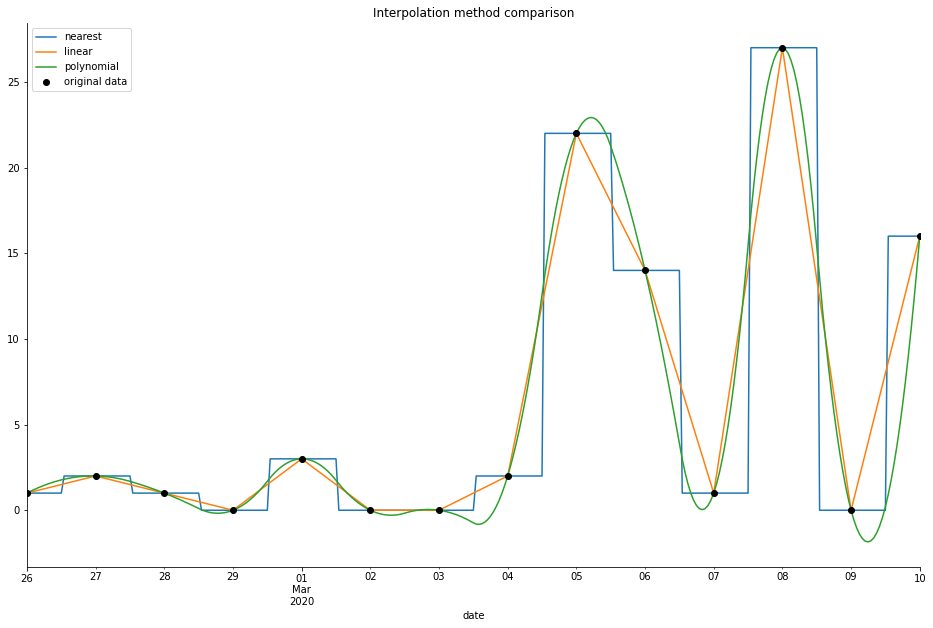

In [57]:
plt.figure(figsize=(16, 10))
ax = plt.gca()

gr_cases2 = gr_cases[:'2020-03-10']

gr_cases2.resample('1H').asfreq().interpolate(method='nearest').plot(ax=ax, label='nearest')
gr_cases2.resample('1H').asfreq().interpolate().plot(ax=ax, label='linear')
gr_cases2.resample('1H').asfreq().interpolate(method='polynomial', order=2).plot(ax=ax, label='polynomial')

ax.scatter(gr_cases2.index, gr_cases2, zorder=10, c='black', label='original data')

ax.legend(loc='upper left')

ax.set_title('Interpolation method comparison')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Rolling

Let's take a look again at the new cases.

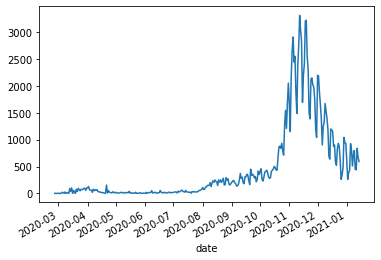

In [58]:
gr['new_cases'].plot()

Ever wonder why the daily new cases are so noisy? The reason is because, depending on the country, on some days (weekends, holidays, etc.) the number of tests is fewer and thus the cases appear to drop. This is problematic, however for analysis. This is why the dataset has another *smooth* version of the `new_cases` variable.

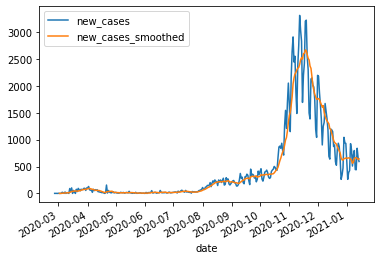

In [59]:
gr[['new_cases', 'new_cases_smoothed']].plot()

If we didn't have `new_cases_smoothed`, how could we generate it on our own? The answer is through a **rolling average**. This involves computing the mean in a constant-length window that *rolls* through the time axis.

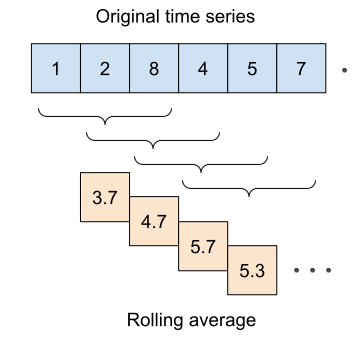

Operations like this that are computed on **rolling windows**, can be performed with the help of [`DataFrame.rolling()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html). This is a very powerful method that essentially groups the DataFrame into its overlapping windows, which can then be used similar to a `.groupby()`.

It might seem similar to undersampling, but it has two main differences:

- it does **not** change the number of datapoints in the series
- its windows **overlap**

In [60]:
gr_cases.head(6)

date
2020-02-26    1.0
2020-02-27    2.0
2020-02-28    1.0
2020-02-29    0.0
2020-03-01    3.0
2020-03-02    0.0
Name: new_cases, dtype: float64

In [61]:
gr_cases.rolling(3).mean().head(6)

date
2020-02-26         NaN
2020-02-27         NaN
2020-02-28    1.333333
2020-02-29    1.000000
2020-03-01    1.333333
2020-03-02    1.000000
Name: new_cases, dtype: float64

For 28 Feburary, the value that we get is the average of the first 3 days (i.e. 26-28 Feb.) By default the value is set to the *right* edge of the window, but we can change this if we want, with the `center` parameter. This is why the first two values of the resulting dataframe are `NaN`.



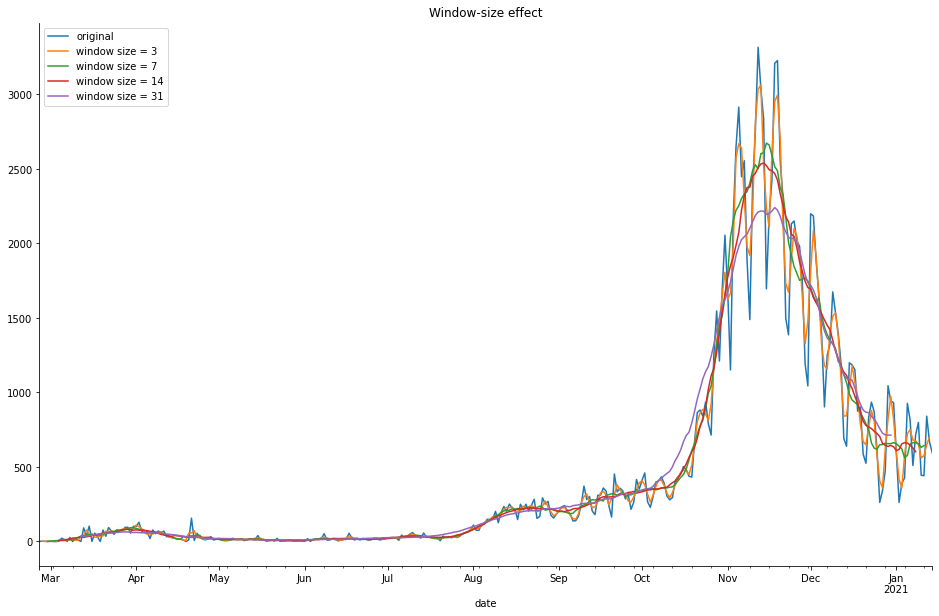

In [62]:
plt.figure(figsize=(16, 10))
ax = plt.gca()

window_sizes = [3, 7, 14, 31]

gr_cases.plot(ax=ax, label='original')

for window in window_sizes:
  gr_cases.rolling(window,center=True).mean().plot(ax=ax, label='window size = {}'.format(window))

ax.set_title('Window-size effect')

ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Timeseries decomposition

In traditional timeseries analysis, the series is assumed to be a function of four components:

- **Level** ($L$). The base value of the series.
- **Trend** ($T$). The tendency of the series (i.e. if it increases or decreases over time).
- **Seasonality** ($S$). Any patterns repeating over time.
- **Noise** ($N$). Whatever can't be explained from the first three components

How do these four components combine two form the timeseries? That depends on what model we consider. There are two main models:

- **Additive**. This model considers the series to be the **sum** of these for components, i.e. $y = L + T + S + N$.
- **Multiplicative**. This model considers the series to be the **product** of these for components, i.e. $y = L \cdot T \cdot S \cdot N$.

Decomposition is the process of splitting a timeseries into its four components. 

Let's first view these four components in practice.

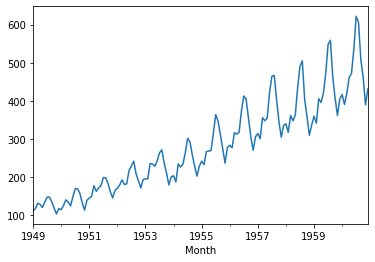

In [63]:
p = df['Passengers']
p.plot()

In this dataset the four components are depicted very clearly. 

First, we'll assume an additive model. 

Let's calculate the firsts two components.

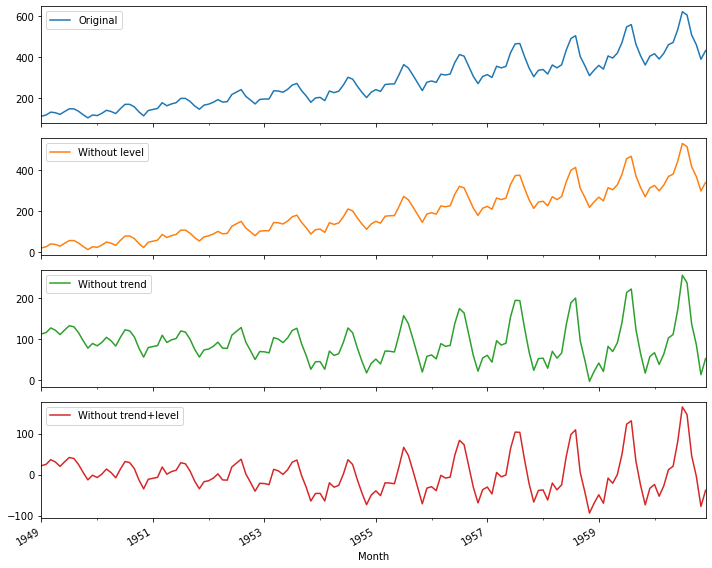

In [64]:
trend, level, *_ = stats.linregress(range(len(df)), df['Passengers'])

p1 = p - level
p2 = p - trend * np.arange(len(p))
p3 = p2 - level

d = pd.DataFrame({'Original': p, 'Without level': p1, 
                  'Without trend': p2, 'Without trend+level': p3})


d.plot(subplots=True, sharex=True, figsize=(10, 8))
plt.tight_layout()

Usually, the trend and level are represented with a regression line.

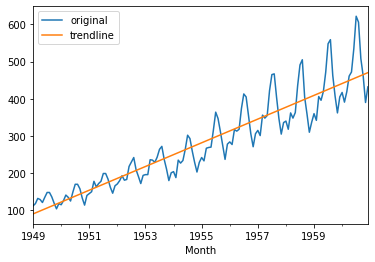

In [65]:
p.plot(label='original')
trendline = pd.Series(trend * np.arange(len(p)) + level, index=df.index)
trendline.plot(label='trendline')
plt.legend()

Another, more naive way to remove the trend and level from a timeseris is **differencing**.

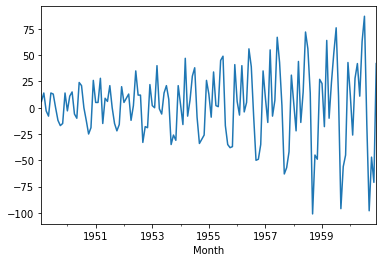

In [66]:
(p[1:] - p[:-1].values).plot()

Obviously there are more sophisticated The trend **isn't** necessarily linear and can change over time.

Now let's see if we can capture the seasonal component. The most naive way to do this is, again, differencing. The idea this time is to not remove the previous value, but the one 1 cycle ago. This doesn't work very well in this dataset though.

Instead we will use an **automatic decomposition** tool, which uses moving averages and is provided by the [statsmodels timeseries analysis module](https://www.statsmodels.org/devel/tsa.html).

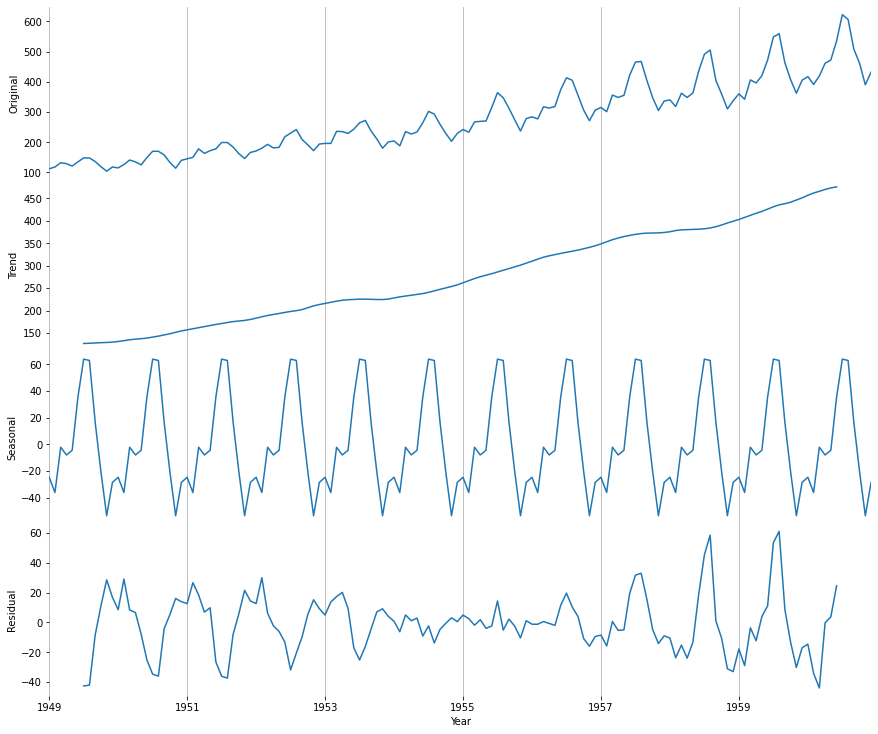

In [67]:
decomposed = seasonal_decompose(p, model='additive')  # additive model

trendline = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid


def modify_axis(ax):

    # Remove x-axis label and x-ticks altogether 
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='both', colors='1')

    # Remove all spines from the axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add a grid on the x-axis major ticks
    ax.grid(axis='x')

    return ax


plt.figure(figsize=(12, 10))

ax = plt.subplot(411)
ax.set_ylabel('Original')
p.plot(ax=ax)
modify_axis(ax)

ax = plt.subplot(412)
ax.set_ylabel('Trend')
trendline.plot(ax=ax)
modify_axis(ax)

ax = plt.subplot(413)
ax.set_ylabel('Seasonal')
seasonal.plot(ax=ax)
modify_axis(ax)

ax = plt.subplot(414)
ax.set_ylabel('Residual')
residual.plot(ax=ax)
ax.set_xlabel('Year')
ax.grid(axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='minor', colors='1')

plt.tight_layout(pad=0)

*Note: `decomposed` does have a `.plot()` method, which is usually used to plot the components. We won't be using this in favor of manually handling plotting.*

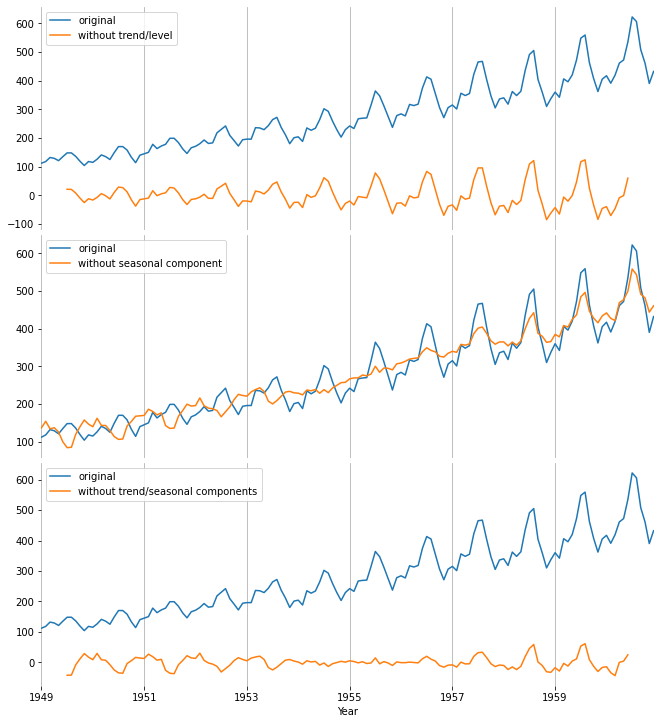

In [68]:
plt.figure(figsize=(9, 10))

ax = plt.subplot(311)
# ax.set_ylabel('Without trend/level')
p.plot(ax=ax, label='original')
(p - trendline).plot(ax=ax, label='without trend/level')
modify_axis(ax)
ax.legend()

ax = plt.subplot(312)
p.plot(ax=ax, label='original')
(p - seasonal).plot(ax=ax, label='without seasonal component')
modify_axis(ax)
ax.legend()

ax = plt.subplot(313)
p.plot(ax=ax, label='original')
residual.plot(ax=ax, label='without trend/seasonal components')
ax.set_xlabel('Year')
ax.grid(axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='minor', colors='1')
ax.legend()

plt.tight_layout(pad=0.5)

Let's try to see if we can identify the same components in Greece's COVID-19 cases.

Here, a multiplicative model will more accurately describe the data.

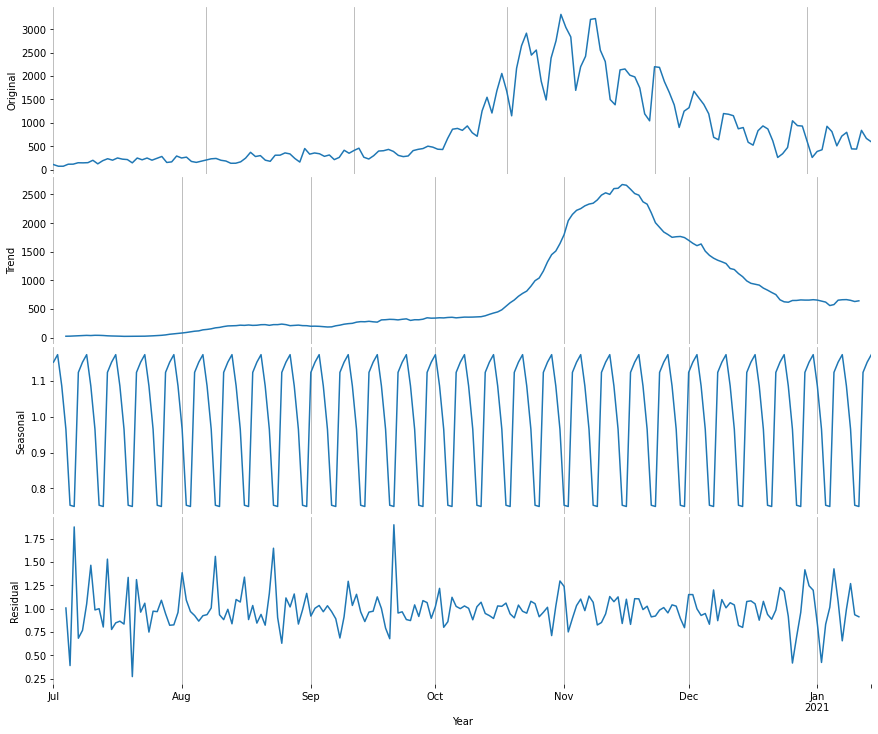

In [69]:
gr_dec = seasonal_decompose(gr.loc['2020-07-01':, 'new_cases'], model='multiplicative')


def modify_axis(ax):

    # Remove x-axis label and x-ticks altogether 
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='both', colors='1')

    # Remove all spines from the axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add a grid on the x-axis major ticks
    ax.grid(axis='x')

    return ax


plt.figure(figsize=(12, 10))

ax = plt.subplot(411)
ax.set_ylabel('Original')
gr.loc['2020-08-01':, 'new_cases'].plot(ax=ax)
modify_axis(ax)

ax = plt.subplot(412)
ax.set_ylabel('Trend')
gr_dec.trend.plot(ax=ax)
modify_axis(ax)

ax = plt.subplot(413)
ax.set_ylabel('Seasonal')
gr_dec.seasonal.plot(ax=ax)
modify_axis(ax)

ax = plt.subplot(414)
ax.set_ylabel('Residual')
gr_dec.resid.plot(ax=ax)
ax.set_xlabel('Year')
ax.grid(axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='minor', colors='1')

plt.tight_layout(pad=0)

*Note: this is an easy way to perform decomposition, however there are more advanced ways, that might yield better results.*

In a future tutorial we'll see how we can model a timeseries in order to **predict future values**.